In [128]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from wordcloud import WordCloud
from spacy.lang.id.stop_words import STOP_WORDS
from gensim.models.phrases import Phrases, Phraser
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay
from tqdm import tqdm

sns.set(style="darkgrid")

In [2]:
train_review_df = pd.read_csv("data/train_data_restaurant.tsv", sep="\t", header=None)
train_review_df.columns = ["review", "sentiment"]

test_review_df = pd.read_csv("data/test_data_restaurant.tsv", sep="\t", header=None)
test_review_df.columns = ["review", "sentiment"]

In [3]:
train_review_df.head()

review sentiment
0  Saya makan di sini dengan menggunakan voucher ...  negative
1  Mas indosat buat main game enemy has been slai...  negative
2  Trus sy percuma dong update no hp terbaru ke c...  negative
3  jika kita pilih dia maka akan ada lebih dari 3...  negative
4  Dikarenakan adik saya suka dengan restoran ini...  negative

In [4]:
train_review_df.count()

review       1780
sentiment    1780
dtype: int64

## Preprocessing Dataset

### Lowercasing

In [5]:
train_review_df["review"] = train_review_df["review"].map(lambda x: x.lower())
test_review_df["review"] = test_review_df["review"].map(lambda x: x.lower())

### Remove punctuations

In [6]:
train_review_df["review"] = train_review_df["review"].map(lambda x: re.sub(r"[^a-zA-Z0-9 ]", "", x))
test_review_df["review"] = test_review_df["review"].map(lambda x: re.sub(r"[^a-zA-Z0-9 ]", "", x))

In [7]:
# split train and validation
train_df, eval_df = train_test_split(train_review_df, test_size=0.1)

print(train_df["review"].count(), eval_df["review"].count(), test_review_df["review"].count())

# resave the data for deep learning training later
train_df[["review", "sentiment"]].to_csv("data/clean_train_data_restaurant.tsv", sep="\t", index=False)
eval_df[["review", "sentiment"]].to_csv("data/clean_eval_data_restaurant.tsv", sep="\t", index=False)
test_review_df[["review", "sentiment"]].to_csv("data/clean_test_data_restaurant.tsv", sep="\t", index=False)

1602 178 185


### Building n-gram

In [8]:
sentences = [x.split(" ") for x in train_review_df["review"].tolist() + test_review_df["review"].tolist()]
bigram_phrases = Phrases(sentences, min_count=10, threshold=1)
trigram_phrases = Phrases(bigram_phrases[sentences], min_count=10, threshold=1)

In [9]:
min_ngram = 10

def merge_ngram(text):
    words = text.split(" ")
    bigrams_ = [b for b in bigram_phrases[words] if b.count('_') == 1]
    trigrams_ = [t for t in trigram_phrases[bigram_phrases[words]] if t.count('_') == 2]

    
    final_text = ""
    in_ngram = False
    i = 0
    
    while i < len(words):
        if i + 2 < len(words):
            if "_".join([words[i], words[i + 1], words[i + 2]]) in trigrams_:
                final_text += "_".join([words[i], words[i + 1], words[i + 2]]) + " "
                i += 2
                in_ngram = True
            elif "_".join([words[i], words[i + 1]]) in bigrams_:
                final_text += "_".join([words[i], words[i + 1]]) + " "
                i += 1
                in_ngram = True
        elif i + 1 < len(words):
            if "_".join([words[i], words[i + 1]]) in bigrams_:
                final_text += "_".join([words[i], words[i + 1]]) + " "
                i += 1
                in_ngram = True
        else:
            final_text += words[i] + " "
#         print(i)
        if not in_ngram:
            final_text += words[i] + " "
        i += 1
        in_ngram = False
    return final_text.strip()

In [10]:
sent = "saya makan di sini dengan menggunakan voucher disdus paket nasi ayam kari dengan diskon hingga 30 persen akibatnya para pengunjung mengantri untuk meredeem voucher cilakanya cek voucher masih dilakukan secara manual tidak ada masalah untuk makanannya hanya saja antrian terlalu lama voucher sendiri sudah dibeli jadi mau tidak mau para pengunjung mengantri"
merge_ngram(sent)

'saya_makan di_sini dengan menggunakan voucher disdus paket nasi ayam kari dengan diskon hingga 30 persen akibatnya para pengunjung mengantri untuk meredeem voucher cilakanya cek voucher masih dilakukan secara manual tidak_ada masalah untuk makanannya hanya_saja antrian terlalu lama voucher sendiri sudah dibeli jadi mau tidak mau para pengunjung mengantri mengantri'

In [11]:
train_review_df["update_review"] = train_review_df["review"].map(merge_ngram)
test_review_df["update_review"] = test_review_df["review"].map(merge_ngram)

## EDA

### Class Balance

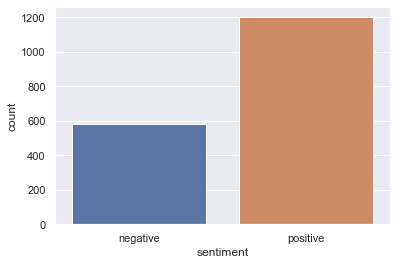

In [12]:
ax = sns.countplot(x="sentiment", data=train_review_df)

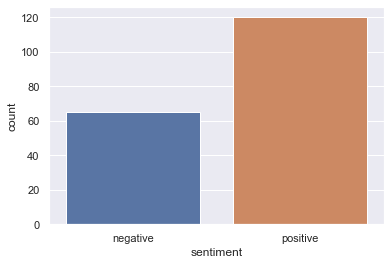

In [13]:
ax = sns.countplot(x="sentiment", data=test_review_df)

In [126]:
test_review_df[test_review_df["sentiment"] == "negative"]["sentiment"].count(), test_review_df[test_review_df["sentiment"] == "positive"]["sentiment"].count()

(65, 120)

### Sentence Length Distribution

[Text(0, 0, '8'),
 Text(0, 0, '9'),
 Text(0, 0, '10'),
 Text(0, 0, '11'),
 Text(0, 0, '12'),
 Text(0, 0, '13'),
 Text(0, 0, '14'),
 Text(0, 0, '15'),
 Text(0, 0, '16'),
 Text(0, 0, '17'),
 Text(0, 0, '18'),
 Text(0, 0, '19'),
 Text(0, 0, '20'),
 Text(0, 0, '21'),
 Text(0, 0, '22'),
 Text(0, 0, '23'),
 Text(0, 0, '24'),
 Text(0, 0, '25'),
 Text(0, 0, '26'),
 Text(0, 0, '27'),
 Text(0, 0, '28'),
 Text(0, 0, '29'),
 Text(0, 0, '30'),
 Text(0, 0, '31'),
 Text(0, 0, '32'),
 Text(0, 0, '33'),
 Text(0, 0, '34'),
 Text(0, 0, '35'),
 Text(0, 0, '36'),
 Text(0, 0, '37'),
 Text(0, 0, '38'),
 Text(0, 0, '39'),
 Text(0, 0, '40'),
 Text(0, 0, '41'),
 Text(0, 0, '42'),
 Text(0, 0, '43'),
 Text(0, 0, '44'),
 Text(0, 0, '45'),
 Text(0, 0, '46'),
 Text(0, 0, '47'),
 Text(0, 0, '48'),
 Text(0, 0, '49'),
 Text(0, 0, '50'),
 Text(0, 0, '51'),
 Text(0, 0, '52'),
 Text(0, 0, '53'),
 Text(0, 0, '54'),
 Text(0, 0, '55'),
 Text(0, 0, '56'),
 Text(0, 0, '57'),
 Text(0, 0, '58'),
 Text(0, 0, '59'),
 Text(0, 0, '6

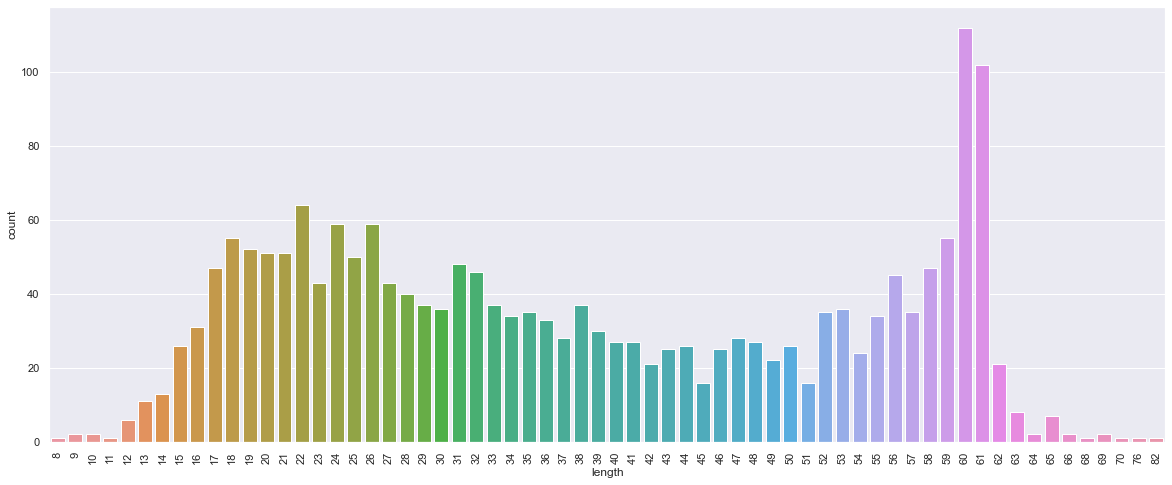

In [14]:
train_review_df["length"] = train_review_df["review"].map(lambda x: len(x.split()))
test_review_df["length"] = test_review_df["review"].map(lambda x: len(x.split()))
combined_df = pd.concat([train_review_df, test_review_df])

plt.figure(figsize=(20, 8))
ax = sns.countplot(x="length", data=combined_df)
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)

### Word distribution (negative review)

In [15]:
id_stopwords = list(STOP_WORDS) + ["yg", "nya", "makanan", "makan", "makanannya"]

[Text(0, 0, 'mahal'),
 Text(0, 0, 'ga'),
 Text(0, 0, 'menu'),
 Text(0, 0, 'enak'),
 Text(0, 0, 'sih'),
 Text(0, 0, 'banget'),
 Text(0, 0, 'harga'),
 Text(0, 0, 'tidak_ada'),
 Text(0, 0, 'aja'),
 Text(0, 0, 'bagus'),
 Text(0, 0, 'kecewa'),
 Text(0, 0, '2'),
 Text(0, 0, 'pelayan'),
 Text(0, 0, 'tempatnya'),
 Text(0, 0, 'steak'),
 Text(0, 0, 'ya'),
 Text(0, 0, 'pelayanan'),
 Text(0, 0, 'harganya'),
 Text(0, 0, 'meja'),
 Text(0, 0, 'pesan'),
 Text(0, 0, 'jam'),
 Text(0, 0, 'pas'),
 Text(0, 0, 'biasa_saja'),
 Text(0, 0, 'gak'),
 Text(0, 0, 'lumayan'),
 Text(0, 0, 'restoran'),
 Text(0, 0, 'orang'),
 Text(0, 0, 'resto'),
 Text(0, 0, 'lanjutan'),
 Text(0, 0, 'standar'),
 Text(0, 0, 'menurut_saya'),
 Text(0, 0, '1'),
 Text(0, 0, 'ke_sini'),
 Text(0, 0, 'di_sini'),
 Text(0, 0, 'makanan_yang'),
 Text(0, 0, 'masuk'),
 Text(0, 0, 'menunggu'),
 Text(0, 0, 'suasana'),
 Text(0, 0, 'order'),
 Text(0, 0, 'dgn'),
 Text(0, 0, 'tempat_ini'),
 Text(0, 0, 'makan_di'),
 Text(0, 0, 'nasi'),
 Text(0, 0, 'ayam')

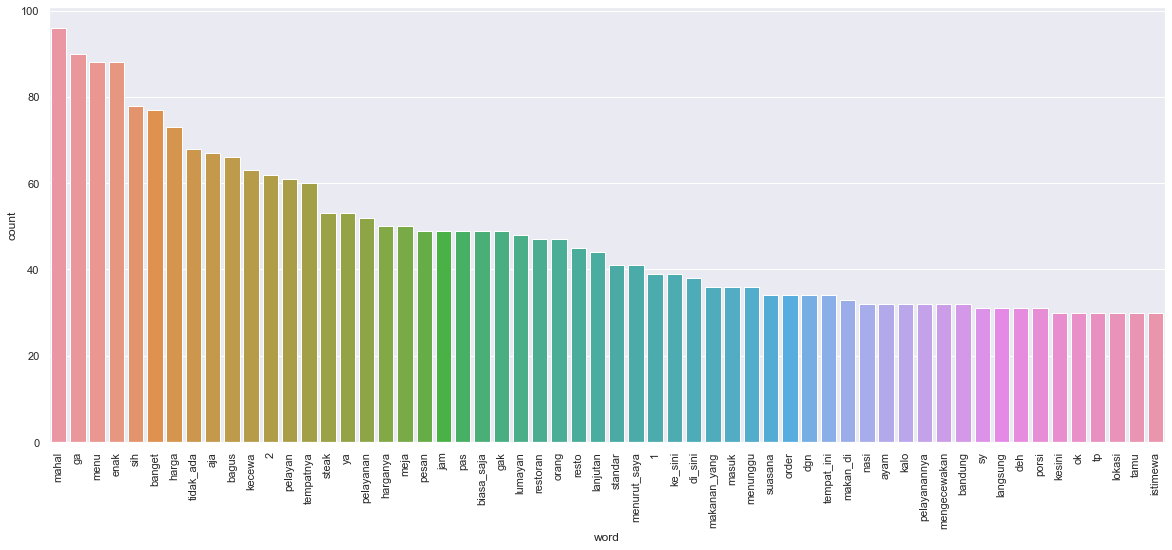

In [16]:
data = train_review_df[train_review_df["sentiment"] == "negative"]["update_review"].tolist() + \
    test_review_df[test_review_df["sentiment"] == "negative"]["update_review"].tolist()
words = [x.split() for x in data]
flatten_words = [item for _words in words for item in _words]
# remove stop words
flatten_words = [word for word in flatten_words if word not in id_stopwords]

word_counter = Counter(flatten_words)
final_tuple = []
for words in word_counter.most_common():
    # find occurence more than 30 only
    if words[1] >= 30:
        final_tuple.append(words)
        
counter_df = pd.DataFrame(final_tuple, columns=["word", "count"])

plt.figure(figsize=(20, 8))
ax = sns.barplot(x="word", y="count", data=counter_df)
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)

### Word distribution (positive review)

[Text(0, 0, 'enak'),
 Text(0, 0, 'menu'),
 Text(0, 0, 'lanjutan'),
 Text(0, 0, 'banget'),
 Text(0, 0, 'tempatnya'),
 Text(0, 0, 'bandung'),
 Text(0, 0, 'ayam'),
 Text(0, 0, 'harga'),
 Text(0, 0, 'di_bandung'),
 Text(0, 0, 'steak'),
 Text(0, 0, 'lumayan'),
 Text(0, 0, 'nasi'),
 Text(0, 0, 'harganya'),
 Text(0, 0, 'pilihan'),
 Text(0, 0, 'pas'),
 Text(0, 0, 'ga'),
 Text(0, 0, 'suka'),
 Text(0, 0, 'tempat_ini'),
 Text(0, 0, 'terjangkau'),
 Text(0, 0, 'mie'),
 Text(0, 0, 'salah_satu'),
 Text(0, 0, 'deh'),
 Text(0, 0, 'jalan'),
 Text(0, 0, 'keluarga'),
 Text(0, 0, 'ikan'),
 Text(0, 0, 'di_sini'),
 Text(0, 0, 'sih'),
 Text(0, 0, 'suasana'),
 Text(0, 0, 'porsi'),
 Text(0, 0, 'nyaman'),
 Text(0, 0, 'goreng'),
 Text(0, 0, 'lokasi'),
 Text(0, 0, 'sambal'),
 Text(0, 0, 'restoran'),
 Text(0, 0, 'mantap'),
 Text(0, 0, 'kesini'),
 Text(0, 0, 'pelayanan'),
 Text(0, 0, 'daging'),
 Text(0, 0, 'cepat'),
 Text(0, 0, 'unik'),
 Text(0, 0, 'standar'),
 Text(0, 0, 'murah'),
 Text(0, 0, 'minuman'),
 Text(0, 0

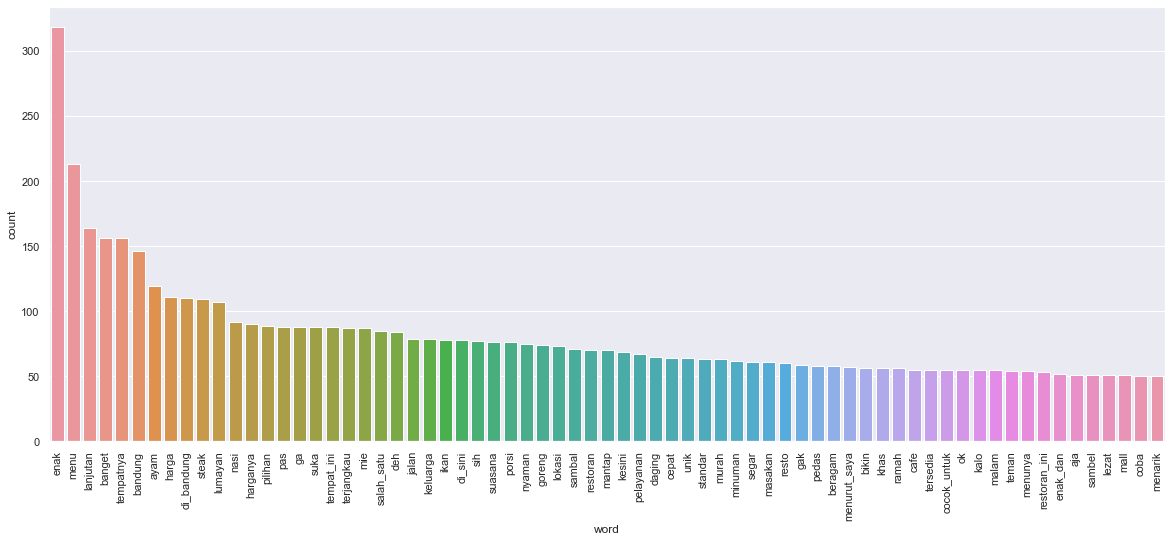

In [17]:
data = train_review_df[train_review_df["sentiment"] == "positive"]["update_review"].tolist() + \
    test_review_df[test_review_df["sentiment"] == "positive"]["update_review"].tolist()
words = [x.split() for x in data]
flatten_words = [item for _words in words for item in _words]
# remove stop words
flatten_words = [word for word in flatten_words if word not in id_stopwords]

word_counter = Counter(flatten_words)
final_tuple = []
for words in word_counter.most_common():
    # find occurence more than 30 only
    if words[1] >= 50:
        final_tuple.append(words)
        
counter_df = pd.DataFrame(final_tuple, columns=["word", "count"])

plt.figure(figsize=(20, 8))
ax = sns.barplot(x="word", y="count", data=counter_df)
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=90)

### Building wordcloud for negative review

In [18]:
data = train_review_df[train_review_df["sentiment"] == "negative"]["update_review"].tolist() + \
    test_review_df[test_review_df["sentiment"] == "negative"]["update_review"].tolist()
text = " ".join(data)

In [19]:
wordcloud = WordCloud(width = 800, height = 800,
                stopwords = id_stopwords, 
                min_font_size = 10).generate(text) 

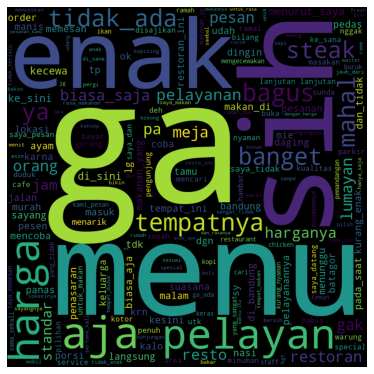

In [20]:
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### Building wordcloud for positive review

In [21]:
data = train_review_df[train_review_df["sentiment"] == "positive"]["update_review"].tolist() + \
    test_review_df[test_review_df["sentiment"] == "positive"]["update_review"].tolist()
text = " ".join(data)

In [22]:
wordcloud = WordCloud(width = 800, height = 800,
                stopwords = id_stopwords, 
                min_font_size = 10).generate(text) 

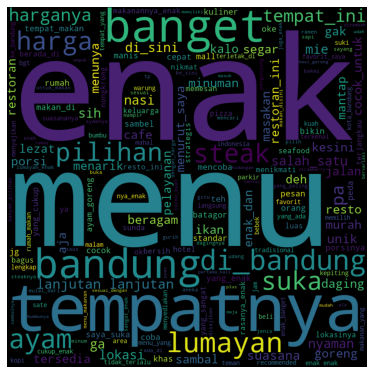

In [23]:
plt.figure(figsize = (5, 5), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

### Sampling data with word "enak"

In [24]:
cnt = 0
for x in train_review_df[train_review_df["sentiment"] == "negative"]["review"].tolist():
    if "enak" in x.split(" "):
        print(x)
        print()
        cnt += 1
        
    if cnt > 10:
        break

beberapa kali saya coba makan malam di sini pelayanannya sangat buruk kurang responsif kepada pengunjung terakhir saya datang saya harus mendatangi kasir untuk meminta menu terakhir saya coba makan pempek di sini tidak seperti dari asalnya rasanya kurang enak dan tidak disediakan sambal sangat tidak memuaskan

saya adalah penggemar steak namun ketika saya makan di abuba ternyata rasanya jauh dari yg pernah dibayangkan bahkan saucenya sangat tidak enak seperti sauce abc biasa katanya barbeque kemudian tidak ada lagi pilihan sauce yg lain tak mau lagi kesini

saya melipir ke ayam goreng raos karena terdesak oleh hujan deras sebelumnya belum pernah mampir ke sini nasi ayam bakar dengan tahu tempe dan es teh manis rp 2500000 agak mahal euy cukup enak sih tapi nggak ada yang spesial baik dari rasa bumbu atau cara penyajian pantes sepi 

seafood beraneka macam  boleh coba gurame goreng garing dan cumi telor asin hanya saja meskipun harga kaki lima tapi rasa agak kurang enak dan makanan bukan

## Baseline Model

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

### Removing stems to reduce the number of vocabs

In [26]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()

train_review_df["stemmed_review"] = train_review_df["review"].map(stemmer.stem)
test_review_df["stemmed_review"] = test_review_df["review"].map(stemmer.stem)

In [27]:
tfidf_vec = TfidfVectorizer(stop_words=id_stopwords, ngram_range=(1, 3), min_df=10)
tfidf_vec = tfidf_vec.fit(train_review_df["stemmed_review"])

train_tfidf_words = tfidf_vec.transform(train_review_df["stemmed_review"])
test_tfidf_words = tfidf_vec.transform(test_review_df["stemmed_review"])

/Users/adityakurniawan/anaconda2/envs/prosa/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['baiknya', 'berkali', 'kali', 'kurangnya', 'mata', 'olah', 'sekurang', 'setidak', 'tama', 'tidaknya'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [28]:
negative_count = train_review_df[train_review_df["sentiment"] == "negative"]["sentiment"].count()
positive_count = train_review_df[train_review_df["sentiment"] == "positive"]["sentiment"].count()
total_count = negative_count + positive_count

negative_weight = 1 - (negative_count / total_count)
positive_weight = 1 - (positive_count / total_count)

negative_weight, positive_weight

(0.6741573033707865, 0.3258426966292135)

In [29]:
clf = LogisticRegression(random_state=1234, solver="liblinear", class_weight={
    "negative": negative_weight,
    "positive": positive_weight
})
clf.fit(train_tfidf_words, train_review_df["sentiment"])

LogisticRegression(C=1.0,
                   class_weight={'negative': 0.6741573033707865,
                                 'positive': 0.3258426966292135},
                   dual=False, fit_intercept=True, intercept_scaling=1,
                   l1_ratio=None, max_iter=100, multi_class='auto', n_jobs=None,
                   penalty='l2', random_state=1234, solver='liblinear',
                   tol=0.0001, verbose=0, warm_start=False)

#### Prediction on Test data

In [30]:
test_y_true = test_review_df["sentiment"].tolist()
test_y_pred = clf.predict(test_tfidf_words)

In [31]:
print(classification_report(test_y_true, test_y_pred))

              precision    recall  f1-score   support

    negative       0.69      0.69      0.69        65
    positive       0.83      0.83      0.83       120

    accuracy                           0.78       185
   macro avg       0.76      0.76      0.76       185
weighted avg       0.78      0.78      0.78       185



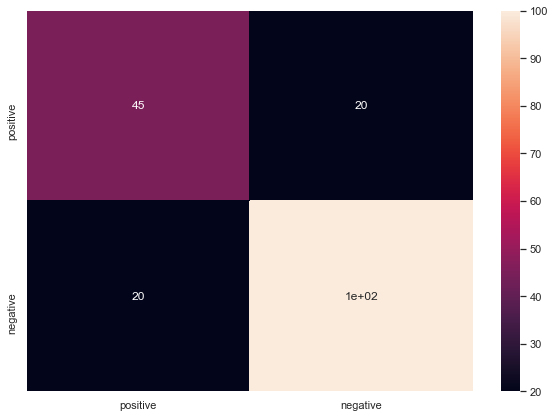

In [132]:
cm = confusion_matrix(test_y_true, test_y_pred)
df_cm = pd.DataFrame(cm, index = ["positive", "negative"],
                  columns = ["positive", "negative"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)

In [120]:
print(precision_recall_fscore_support(test_y_true, test_y_pred, average="micro"))

(0.7837837837837838, 0.7837837837837838, 0.7837837837837838, None)


#### Prediction on Train data

In [33]:
train_y_true = train_review_df["sentiment"].tolist()
train_y_pred = clf.predict(train_tfidf_words)

In [34]:
print(classification_report(train_y_true, train_y_pred))

              precision    recall  f1-score   support

    negative       0.77      0.88      0.82       580
    positive       0.94      0.88      0.90      1200

    accuracy                           0.88      1780
   macro avg       0.85      0.88      0.86      1780
weighted avg       0.88      0.88      0.88      1780



In [35]:
print(confusion_matrix(train_y_true, train_y_pred))

[[ 509   71]
 [ 150 1050]]


In [119]:
print(precision_recall_fscore_support(train_y_true, train_y_pred, average="micro"))

(0.8758426966292134, 0.8758426966292134, 0.8758426966292135, None)


#### Merge all into dataframe

In [36]:
train_review_df["predicted_sentiment"] = train_y_pred
test_review_df["predicted_sentiment"] = test_y_pred

## Baseline Model Evaluation

### Training data prediction evaluation

In [37]:
pd.set_option('display.max_colwidth',1000)
pd.set_option('display.max_rows',100)

In [38]:
train_data_df = train_review_df[train_review_df["predicted_sentiment"] != train_review_df["sentiment"]][["review", "sentiment", "predicted_sentiment"]]

In [39]:
train_data_df.sample(n=50, random_state=0).head(50)

review  \
989                                                                                                                                                                             rumah makan padang ini tempatnya lumayan bersih menu nya seperti masakan padang yang lain ada rendang telur nangka dll untuk rasanya enak dan standar masakan padang yang agak berminyak harga nya ga terlalu mahal ga murah banget juga jadi cocok lah makan masakan padang disini siang hari   
1616                                                                                                                                                                                                                                                     mau kesini parkir nya emang aga susah mesti muter bbrp kali tp tukang parkir nya sigap bgt ko waktu itu jg lagi hujan mereka sangat memperhatikan kita yang akan turun dr mobil pelayanan ok tomyam seafood nya seger   
1029                                                             awal agustus 2016 saya cari restoran di sukajadi ini karena kebetulan lewat dekat situ dan pengen makan tapi bolakbalik jalan sukajadi dari cemara sampai belokan taman pertigaan yg ada halte tetap tidak dapat menemukan restoran ini kalau untuk dcost lainnya di bandung saya kasih nilai ratarata tapi slogan harga kaki limanya kayanya perlu diperbaiki karena sudah tidak murah seperti dulu lanjutan   
557                                                                                                                                                                                                                                                                                               tempatnya oke untuk hangout sekedar ngobrol2 bersama teman tapi makanan di sini kurang enak sebaiknya pesan minuman atau starter saja untuk main course sangat tidak rekomen   
1425                                                                                                                                                                                      penggemar fotoo wajib ke sini lebih2 para ladies psti sukaa di sini design ruangan ny eye catching bngett cocok buat popopotoan hahahah  eits tpi di sini ga cuma jual tempat doang yg makanan ny ga enakk di sini tempat ok  makanan ny jga ga kalah ok broo jadi cobain dee hahaha   
1079                                                   kami dalam perjalanan ke lembang dalam keadaan lapar saat melihat saung pengkolan ini kami langsung berhenti untuk makan kami memilih lesehan di lantai 2 sehingga mendapatkan pemandangan yang indah pesanan kami adalah cumi goreng tepung gurame goreng crispy tumis genjer dan dua menu tahu yang saya lupa namanya secara keseluruhan tidak ada yang istimewa dari hidangan tersebut mungkin pilihan saya lanjutan   
441                                                                                                                                                                  tempatnya seru untuk sekedar foto alias instagramable suasananya asik dan cocok untuk nongkrong karena udaranya dingin akses menuju lokasi agak susah karena terletak di dalam kawasan perumahan dan sesuai namanya agak modjok menu makanan dan minumannya menurut saya biasa saja tidak ada yg istimewa   
586                                                                                                                                                                                                                                                                                                   pelayanan cukup baik minuman agar selalu menggunakan bahanbuah2an yg msh baik dan layak utk dikonsumsi pastikan kelengkapan cashier semuanya berfungsi dg baik good luck   
551                                                                                                                                                                                                                                                                   

### Testing data prediction evaluation

In [40]:
test_data_df = test_review_df[test_review_df["predicted_sentiment"] != test_review_df["sentiment"]][["review", "sentiment", "predicted_sentiment"]]

In [41]:
test_data_df.head(40)

review  \
0                                                                                                                                                                         tempatnya sih menarik mudah dijangkau dari segala arah menu yang disajikan cukup variatif dan ditata dengan rapih sebetulnya cukup nikmat tapi tidak sesuai list harga urtuk makanan sama sekali tidak ada saya pilih sayur bunga pepaya mungkin ditambah kata pedas tapi yang disajikan malah lebih banyak cabenya daripada bunga pepaya   
6                                                                                                                                                                                                                                                                                                                                                                                               ditempat ini satenya enak hanya saja bumbunya ngga masuk menurut saya bumbunya kurang enak overalll jadi biasa saja   
7                                                                                                                                                                                                                                                                                                                                                                               diajakin temen waktu masih kuliah katanya satenya enak    tapi setelah dicoba kurang masuk sama selera saya    hehe just my opinion   
8                                                                                                                                                                                                                                                                                                                                mie rica babinya terkenal enaknya dan jangan lupa pesan pangsit serta udang gorengnya juga satu kekurangan dari restarant ini ada di kuahnya kuahnya serasa hambar alias tasteless   
11                                                                                                                                                                       saya mencoba menu mie yamin di batagor kingsley rasanya enak tetapi harganya relatif mahal untuk ukuran mie yamin saya pun membeli oleholeh batagor kingsley harganya tergolong mahal 1 porsi isi 3 buah  rp 40500 dengan ukuran yang relatif kecil batagor di depan kartika sari dago bisa dijadikan alternatif makan batagor di bandung    
15                                                                                                                                                                                                                                                                                                                                                                                    batagornya enak tapi bila diukur dengan harganya kok sepertinya overpriced and overvalue cukup sekali tidak akan mencoba lagi   
16                                                                                                                                                                                                                                                dari segi rasa tidak jauh berbeda dengan batagor sejenis lainnya mungkin karena sudah punya nama yang cukup terkenal jadi harganya pun ikut menyesuaikan walaupun porsinya tidak ikut menyesuaikan buat kami mungkin bukan jadi pilihan utama untuk makan di sini   
17                                                                                                                                                                                                                                                                                                                                             rasa batagor biasa saja bumbu kacangnya cukup enak dan halus tp harga nya yg tlalu mahal dgn rasa yg standar membuat tidak cocok 1 por

In [123]:
neg_count = test_data_df[test_data_df["sentiment"] == "negative"]["predicted_sentiment"].count()
pos_count = test_data_df[test_data_df["sentiment"] == "positive"]["predicted_sentiment"].count()

neg_count, pos_count

(20, 20)

## Deep Learning Evaluation

In [42]:
import torch
from dl_model_experiments import model_fn, logits_to_binary, load_model

In [95]:
text_field = torch.load("model/text_field.pt")
sentiment_field = torch.load("model/sentiment_field.pt")
hp = {
    "min_freq": 5,
    "batch_size": 128,
    "embedding_size": 300,
    "lstm_hidden_size":64,
    "lstm_bidirectional": True,
    "lr": 0.001,
}
num_vocab = len(text_field.vocab.itos)
model_weight = load_model("model/sentiment_batch_size_128_embedding_size_300_lr_0.001_lstm_bidirectional_True_lstm_hidden_size_64_min_freq_5_pretrained_False.pt")
model = model_fn(hp, num_vocab)
model.load_state_dict(model_weight)
model.eval()

Classifier(
  (embedding): NormalEmbedding(
    (_emb): Sequential(
      (0): Embedding(1613, 300)
      (1): Dropout(p=0.6, inplace=False)
    )
  )
  (encoder): LSTMEncoder(
    (_encoder): LSTM(300, 64, bidirectional=True)
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (1): Linear(in_features=128, out_features=1, bias=True)
    )
  )
)

In [96]:
def predict_fn(query):
    text = text_field.preprocess(query)
    text = text_field.numericalize(([text], [len(text)]))
    words = text[0]
    seq_len = text[1]
#     print(words.size(), seq_len)

    with torch.no_grad():
        logits = model(words, seq_len)
        prediction = logits_to_binary(logits).item()
    sentiment = sentiment_field.vocab.itos[int(prediction)]
    return sentiment

In [112]:
predict_fn("warungnya oke makanannya enak lokasinya pinggir jalan mudah dijangkau")

'positive'

In [113]:
train_review_df["predicted_sentiment_dl"] = train_review_df["review"].map(predict_fn)
test_review_df["predicted_sentiment_dl"] = test_review_df["review"].map(predict_fn)

In [114]:
test_data_dl_df = test_review_df[test_review_df["predicted_sentiment_dl"] != test_review_df["sentiment"]][["review", "sentiment", "predicted_sentiment_dl"]]

In [115]:
test_data_dl_df.count()

review                    18
sentiment                 18
predicted_sentiment_dl    18
dtype: int64

In [116]:
test_data_dl_df.head(100)

review  \
1                                                                                                                                      lokasi strategis penasaran karena daerah situ rame trus parkirannya entah yg ke hdl atau ke alas daun ya rame2 sama keluarga rasa biasa aja mahal iya sayur seuprit tempatnya juga biasa aja yang beda cuma makan pake alas daun pisang   
8                                                                                                                                                                                           mie rica babinya terkenal enaknya dan jangan lupa pesan pangsit serta udang gorengnya juga satu kekurangan dari restarant ini ada di kuahnya kuahnya serasa hambar alias tasteless   
11                                  saya mencoba menu mie yamin di batagor kingsley rasanya enak tetapi harganya relatif mahal untuk ukuran mie yamin saya pun membeli oleholeh batagor kingsley harganya tergolong mahal 1 porsi isi 3 buah  rp 40500 dengan ukuran yang relatif kecil batagor di depan kartika sari dago bisa dijadikan alternatif makan batagor di bandung    
13                                                                                                                                                                                                                                          kebetulan dekat tempat menginap di asia afrika jalan kaki hanya 500m teman titip beli buat oleh oleh rasa biasa saja lumayan mahal   
15                                                                                                                                                                                                                                               batagornya enak tapi bila diukur dengan harganya kok sepertinya overpriced and overvalue cukup sekali tidak akan mencoba lagi   
18                                                                                                                                                                                                                                                            pioner batagor di bandung selain batagor iksan dan batagor riri rasa ikan lumayan terasa namun tidak seenak dulu   
20                                                                                                                                                                                  ini yg terkenal di bandung kalo belum pernah bsa cobain rasanya so so aja bisa pesen batagor campur  batagorsiomay ada juga mie kocok roti ronde dll untuk rasa nggak ada yang spesial sih   
24                                                                                                                                                                                                                                                            emmm sedih deh kalo kesini selalu waiting  mie nya pedes bangethehe  bangkunya juga tambahin dong biar ga nunggu   
31                                                                                                                                                                                                                                          tampak biasa aja setelah kurang lebih 5 taun yg lalu saat saya pertama kesini kualitas rasa juga berkurang  harga makin mahal juga   
35                                                                                                                                                                nasi campur ab du tikungan jalan kalipah apo dan pajagalan nasi campur dan nasi hainam  ya biasabiasa saja  tak ada yg special juga daging nya di potong terlalu tipis service dan pelayanan juga biasabiasa   
41                                                                                                                                                                                  tempat cocok untuk bersantai sayangnya pada saat weekend pengunjung sangat padat tempat parkir selalu penuh da

In [117]:
print(classification_report(test_review_df["sentiment"], test_review_df["predicted_sentiment_dl"]))

              precision    recall  f1-score   support

    negative       0.93      0.78      0.85        65
    positive       0.89      0.97      0.93       120

    accuracy                           0.90       185
   macro avg       0.91      0.88      0.89       185
weighted avg       0.90      0.90      0.90       185



In [118]:
print(precision_recall_fscore_support(test_review_df["sentiment"], test_review_df["predicted_sentiment_dl"], average="micro"))

(0.9027027027027027, 0.9027027027027027, 0.9027027027027028, None)


In [125]:
neg_dl_count = test_data_dl_df[test_data_dl_df["sentiment"] == "negative"]["predicted_sentiment_dl"].count()
pos_dl_count = test_data_dl_df[test_data_dl_df["sentiment"] == "positive"]["predicted_sentiment_dl"].count()

neg_dl_count, pos_dl_count

(14, 4)

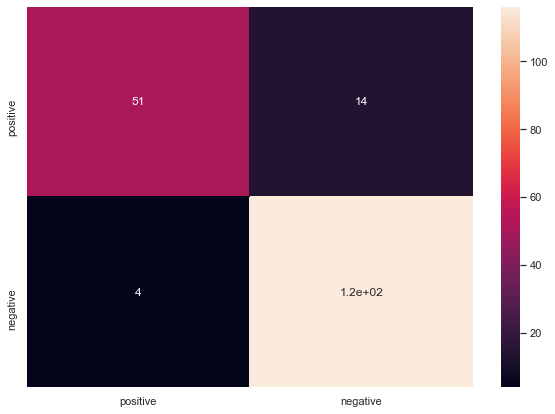

In [133]:
cm = confusion_matrix(test_review_df["sentiment"], test_review_df["predicted_sentiment_dl"])
df_cm = pd.DataFrame(cm, index = ["positive", "negative"],
                  columns = ["positive", "negative"])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True)